# <center>Mouse Brain from neurons to brain regions</center>
## <center>application of co-simulation TVB-Nest multiscale</center>

<div class="alert alert-block alert-warning">
    <h1 id="Installation before usage">Installation before usage<a class="anchor-link" href="Installation-before-usage"></a>
        </h1>
    <h3><strong>You can't run the notebook on this platform.</strong></h3>
    <h3>The step for the installation is the following:</h3>
        <ul>
            <li>Install singularity : <a href=https://singularity.lbl.gov/quickstart> https://singularity.lbl.gov/quickstart </a></li>
          <li>Download the singularity notebook : <strong>Nest_TVB_full.simg</strong> and the notebook from the Storage of the Collab in <strong>one folder</strong></li>
          <li>Open an terminal in this folder</li>
          <li>Execute the next command : <strong>singularity run --app jupyter-notebook ./Nest_TVB_full.simg</strong></li>
          <li>Open the link of the jupyter notebook</li>
          <li>Open the notebook </li>
        </ul>
</div>

![alt text](/home/nest_elephant_/parameter/data_mouse/co_simulation_no_title.png)

This jupyter notebook is a demonstration of the co-simulation between Nest and TVB. It is based on the simulation of The Virtual Mouse Brain using <a href='#di_volo2019'> Mean Adaptative Exponential model </a>. The regions of the right entorhinal area lateral part and the left entorhinal area lateral part will be simulated by spiking neural network using Nest.

The demonstration is composed of three parts :
   * The description and the determination of all parameters for the simulation.
   * The running of the simulation.
   * Plot simulated data.

The goal of this demonstration is just to show the capability of the implementation but a realistic simulation.

In [1]:
%%capture --no-display
%matplotlib notebook
# library for the notebook
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import os
import time
# import library of the application
from nest_elephant_tvb.orchestrator.parameters_manager import save_parameter,create_linked_parameters
import nest_elephant_tvb.orchestrator.run_exploration as orchestrator
from nest_elephant_tvb.analyse.get_data import get_rate,get_data_all
from nest_elephant_tvb.analyse.neuron_widget import neuron_widget
from nest_elephant_tvb.analyse.print_connectome import display_connectome
from nest_elephant_tvb.analyse.print_nest_pop import print_nest_pop

# hidden cell
from IPython.core.display import display, HTML, Javascript
def hide_from_add(name):
    string_code='''
    <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="'''+name+ '''"></form>
    '''
    return string_code
hide_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>
'''

display(HTML(hide_code_prepare_str))
def hide_from(name):
    display(HTML(hide_from_add(name)))
hide_from('import function')

# size of the autoscrolling
def size_auto_scroll(nb=100):
    display(Javascript("IPython.OutputArea.auto_scroll_threshold="+str(nb)+";"))

# color of the printing
color_Nest = 'gold'
color_TVB  = 'darkgreen'

# 1. Determine parameters of the simulation

In [2]:
param={}

## 1.1 parameters for Nest simulator

### 1.1.a parameters for Nest kernel (<a href=https://nest-simulator.readthedocs.io/en/nest-2.20.1/ref_material/pynest_apis.html#module-nest.lib.hl_api_simulation>documentation</a>)

In [3]:
param['param_nest'] = {
    "sim_resolution": 0.1,        # precision of the simulation 
    "master_seed": 46,            # seed for the random generator of Nest 
    "total_num_virtual_procs": 10,# the number of virtual processors 
    "overwrite_files": False,     # 
    "print_time": True,           # print time (it's not working for the moment)
    "verbosity": 20}              # verbosity of Nest

### 1.1.b parameters of the neurons

The model of spiking neurons is the **adaptive and exponential integrate and fire** with **exponential conductance synapses** <a href='#brette_2005'> [Brette and Gerstner 2005]</a> 

**Neuron dynamic** :

\begin{equation}
    \begin{aligned}
        C_m\times \frac{dV_m}{dt} =& -g_L(V_m-E_L)+g_L\Delta_T e^{ \frac{V_m-V_{th}}{\Delta_T} }\\
        &-g_e(t)(V_m-E_{ex}) -g_i(t)(V_m-E_{in})- \text{W} +I_e\\
        \tau_w \frac{d\text{W}}{dt}=& a(V_m-E_L) -\text{W}
    \end{aligned}
\end{equation}

**Synaptic connection** :

\begin{equation}
			g_e(t) = \sum_{t_j^{(f)}} w_j e^{-\frac{t-t_j^{(f)}}{\tau_{ex}}}  \, \mathcal{H}(t-t_j^{(f)})\text{ for }w_j > 0.0\\
			g_i(t) = \sum_{t_j^{(f)}} w_j e^{-\frac{t-t_j^{(f)}}{\tau_{in}}}  \, \mathcal{H}(t-t_j^{(f)})\text{ for }w_j < 0.0\\
\end{equation}

with $t_j^{(f)}$ is the $f^{th}$ spike of the neurons j.

__reset condition__:

$V_m ([t^{(f)};t^{(f)}+t_{ref}])=V_{reset}$ with $t^{(f)}=\{ t|V_m(t)=V_{peak}\}$\
$\text{W} ([t^{(f)};t^{(f)}+t_{ref}])=\text{W}(t^{(f)})+b$ with $t^{(f)}=\{t|V_m(t)=V_{peak}\}$

__initial condition__:

$V_m(0)=-70.6$mV and $\text{W}(0)=0.0$


__Parameters by default of neuron__ :<a id="parameter_neuron"></a>

$C_m$ double - Capacity of the membrane (281.0 pF).\
$t_{ref}$ double - Duration of refractory period (0.0 ms).\
$V_{reset}$ double - Reset value for $V_m$ after a spike (-60.0 mV).\
$E_L$ double - Leak reversal potential (-70.6 mV).\
$g_L$ double - Leak conductance (30.0 nS).\
$V_{peak}$ double - Spike detection threshold (0.0 mV).\
$a$ double - Subthreshold adaptation (4.0 nS).\
$b$ double - Spike-triggered adaptation (80.5 pA).\
$\Delta_T$ double - Slope factor (2.0 mV).\
$\tau_w$ double - Adaptation time constant (144.0 ms).\
$V_{th}$ double - Spike initiation threshold (-50.4 mV).\
$I_e$ double - Constant external input current (700 pA).\
$E_{ex}$ Excitatory reversal potential (0.0 mV)\
$\tau_{ex}$ Rise time of excitatory synaptic conductance (0.2ms)\
$E_{in}$ Inhibitory reversal potential (-85.0 mV)\
$\tau_{in}$ Rise time of inhibitory synaptic conductance(2.0ms)

You can find the paremeter for excitatory neurons. If you want change parameters, the following widget will help you.

In [4]:
size_auto_scroll(500)

<IPython.core.display.Javascript object>

In [5]:
neuron_widget(nb_thread=4)

interactive(children=(IntSlider(value=80, description='N_ex = Number of source neurons', layout=Layout(height=…

In [6]:
size_auto_scroll()

<IPython.core.display.Javascript object>

Determine the parameter of the **gaussian distribution** of the initial condition of the neurons and the external current.

In [7]:
param['param_nest_topology'] = {
    "neuron_type": "aeif_cond_exp", # this model is the adaptive exponential 
                                    # integrate and fire neuron with conductance
                                    # exponential synapse (can be changed)
    "param_neuron_excitatory": {
        "C_m": 200.0, 
        "t_ref": 5.0,
        "V_reset": -64.5, 
        "E_L": -64.5,
        "g_L": 10.0, 
        "I_e": 0.0, 
        "a": 0.0, 
        "b": 1.0,
        "Delta_T": 2.0,
        "tau_w": 500.0, 
        "V_th": -50.0,
        "E_ex": 0.0, 
        "tau_syn_ex": 5.0, 
        "E_in": -80.0, 
        "tau_syn_in": 5.0}, 
    "param_neuron_inhibitory": {
        "C_m": 200.0,
        "t_ref": 5.0, 
        "V_reset": -65.0, 
        "E_L": -65.0, 
        "g_L": 10.0, 
        "I_e": 0.0, 
        "a": 0.0, 
        "b": 0.0, 
        "Delta_T": 0.5, 
        "tau_w": 1.0, 
        "V_th": -50.0, 
        "E_ex": 0.0, 
        "tau_syn_ex": 5.0, 
        "E_in": -80.0, 
        "tau_syn_in": 5.0},
}

Determine the parameter of the **gaussian distribution** of the initial condition of the neurons and the external current.

In [8]:
param['param_nest_topology'].update({
    "mean_I_ext": 0.0, # mean of external constant current
    "sigma_I_ext": 0.0,# standard deviation of the external constant current 
    "sigma_V_0": 0.0,  # the mean is defined by the V_reset
    "mean_w_0": 0.0,   # sigma and mean of the distribution are equal
})

Determine the number of excitatory and inhibitory neurons by region and the total neurons of the simulation.\
The actual example is based on a <a href='#image_connectome'>connectome</a> of the mouse brain of 104 regions. The number of the region needs to be between 1 and 104 regions.

In [9]:
param['param_nest_topology'].update({
    "nb_region": 104,   # this is the number of the total number of regions
                        # for the simulation. It's not the number of regions
                        # simulated in Nest
    "nb_neuron_by_region": 1000, # few for reducing the time simulation
    "percentage_inhibitory": 0.2,
})

### 1.1.b Parameters for the connectivity between neurons

Connections inside the region

In [10]:
param['param_nest_connection'] = {
    "weight_local": 1.0, # weight of excitatory synapses
    "g": 5.0,            # ratio between inhibitory and excitatory synapses
    "p_connect": 0.05,   # probability of connection between neurons ( based on pairwise-bernoulli distribution)
}

Connections between region (<a href='#image_connectome'>connectome</a>)

In [11]:
param['param_nest_connection'].update({
    "weight_global": 1.0,        # the weight of synapses between region
    "nb_external_synapse": 78,   # the number of external connections receives by neurons
    # The weight over the connection between regions.
    # In this application the weight defines the percentage of connection from each region.
    # The weights are normalized in order to have the sum of weight incoming equal to 1
    "path_weight": "/home/nest_elephant_tvb/parameter/data_mouse//weights.npy",
    # the distance is the simple euclidean distance between the centre of each region.
    # You can change in a more realistic tract length connection between region.
    "path_distance": "/home/nest_elephant_tvb/parameter/data_mouse//distance.npy",
    "velocity": 3.0               # this is the speed of the transmission between regions in mm/s
})

### 1.1.c Parameters of the background (noise, Poisson generator, stimulus, multimeter, spike detector, ...)

#### External input

In this example, the external stimulation is represented by an independent Poisson generator for all neurons.
The other type of stimulus can be added to the actual API.

In [12]:
param['param_nest_background'] = {
    "poisson": True, 
    "rate_ex": 0.0,        # rate of external excitatory input for all neurons 
    "rate_in": 0.0,        # rate of external inhibitory input for all neurons
    "weight_poisson": 1.0, # weight on the synapse connection 
    "noise": False,        # white noise input of the voltage membrane of neurons
    "stimulus": False,     # not yet implemented
}

#### Recorder

Devices to record the neurons activities.

The index of the neurons are known before the simulation. At the begging of the simulation, there is a plot of index of neurons in type and region. 

In [13]:
param['param_nest_background'].update({
    "multimeter": True, 
    "multimeter_list": {
        "pop_1_ex_VM": [["V_m"], 0, 10],     # record Voltage membrane of 10 excitatory neurons
        "pop_1_ex_W": [["w"], 0, 10],        # record adaptation of 10 excitatory neurons
        "pop_1_in_VM": [["V_m"], 800, 810],  # record Voltage membrane of 10 inhibitory neurons
        "pop_1_in_W": [["w"], 800, 810]      # record adaptation of 10 inhibitory neurons
    }, 
    "record_spike": True, 
    "record_spike_list": {       
        "pop_1_ex": [0, 800],                # record spikes of excitatory neurons of the first population
        "pop_2_ex": [1000, 1799],            # record spikes of inhibitory neurons of the first population
        "pop_1_in": [800, 999],              # record spikes of excitatory neurons of the second population
        "pop_2_in": [1800, 1999]             # record spikes of inhibitory neurons of the second population
    },
})

## 1.2 parameters for TVB simulator

### 1.2.a parameters for Neural Mass Mass model

<mark>The commented parameters are defined by the link of the previous parameters. The function which creates links is <a href='#create_link'> create_linked_parameters</a> .</mark>

The Neural Mass is based on <a href='#di_volo2019'> [ Di Volo 2019 ]</a>.
You can find the equation just above:

<div style="-webkit-column-count: 3; -moz-column-count: 3; column-count: 3; -webkit-column-rule: 1px dotted #e0e0e0; -moz-column-rule: 1px dotted #e0e0e0; column-rule: 1px dotted #e0e0e0;">
    <div style="display: inline-block;">
\begin{equation}
			\forall \mu,\lambda,\eta \in \{e,i\}^3\, ,
			\left\{
			\begin{split}
			T \, \frac{\partial \nu_\mu}{\partial t} = & (\mathcal{F}_\mu - \nu_\mu )
			+ \frac{1}{2} \, c_{\lambda \eta} \, 
			\frac{\partial^2 \mathcal{F}_\mu}{\partial \nu_\lambda \partial \nu_\eta} \\
			T \, \frac{\partial c_{\lambda \eta} }{\partial t}  =  & A_{\lambda \eta} +
			(\mathcal{F}_\lambda - \nu_\lambda ) \, (\mathcal{F}_\eta - \nu_\eta ) \\
			&+ c_{\lambda \mu} \frac{\partial \mathcal{F}_\mu}{\partial \nu_\lambda} +
			c_{\mu \eta} \frac{\partial \mathcal{F}_\mu}{\partial \nu_\eta} 
			- 2  c_{\lambda \eta}\\
            \frac{\partial W}{\partial t} = &-\frac{W}{\tau_w}+b\nu_e+a\mu_{V_e} 
			\end{split}
			\right.
\end{equation}
    </div>
    <div style="display: inline-block;">
with
            </div>
    <div style="display: inline-block;">
\begin{equation}
			A_{\lambda \eta} =  
			\left\{
			\begin{split}
			\frac{\mathcal{F}_\lambda \, (1/T - \mathcal{F}_\lambda)}{N_\lambda} 
			\qquad & \textrm{if  } \lambda=\eta \\
			0 \qquad & \textrm{otherwise}
			\end{split}
			\right.
\end{equation}
    </div>
</div>

The transfert function of the mean field :

\begin{equation}
			  			F_{\mu}(\nu_e,\nu_i) = \frac{1}{2\,\tau_V} {Erfc}(\frac{V_{thre}^{eff}-\mu_V}{\sqrt{2} \, \sigma_V})
\end{equation}\
The voltage threshold :
\begin{equation}
			\begin{split}
			V_{thre}^{eff} & (\mu_V, \sigma_V, \tau_V^N) =& P_0 + 
			\sum_{x \in \{ \mu_V, \sigma_V, \tau_V^N\}} P_x \left(  \frac{x - x^0}{\delta x^0} \right) \\
            &&+ \sum_{ x,y \in \{ \mu_V, \sigma_V, \tau_V^N\}^2} P_{xy}
			\left( \frac{x - x^0}{\delta x^0}  \right) \,  \left( \frac{y - y^0}{\delta y^0} \right)
			\end{split}
\end{equation}\
The mean conductance of the populations:
\begin{equation}
				\mu_G(\nu_e,\nu_i) =(\nu_eK_e\tau_eQ_e)+(\nu_iK_i\tau_iQ_i) +g_L
\end{equation}
The  mean voltage fo the population:
\begin{equation}
				\mu_V(\nu_e,\nu_i) =\frac{(\nu_eK_e\tau_eQ_e)E_e+(\nu_iK_i\tau_iQ_i)E_i +g_LE_L}{\mu_G}
\end{equation}
The standard deviation of the voltage:
\begin{equation}
				\sigma_V(\nu_e,\nu_i) =\sqrt{\sum_{s\in\{e,i\}}K_s\nu_s\frac{\left(\frac{Q_s}{\mu_G}(E_s-\mu_V)\tau_s\right)^2}{2\frac{C_m}{\mu_G}+\tau_s}}
\end{equation}
The time constant of the mean voltage:
\begin{equation}
				\tau_V(\nu_e,\nu_i) =\frac{\sum_{s\in\{e,i\}}K_s\nu_s\left(\frac{Q_s}{\mu_G}(E_s-\mu_V)\tau_s\right)^2}{\sum_{s\in\{e,i\}}K_s\nu_s\frac{\left(\frac{Q_s}{\mu_G}(E_s-\mu_V)\tau_s\right)^2}{2\frac{C_m}{\mu_G}+\tau_s}}
\end{equation}

Remarque : Most of the <a href="#parameter_neuron">parameter of the neurons and synapses</a> are present in the above equation ( g_L, E_L, C_m, a, b, tau_w, E_e, E_i, tau_e, tau_i). The other parameters are from the network configuration (Q_e, Q_i, N_tot, p_connect, g, K_ext_e) and from the definition of the mean field (T, P_e, P_i).

The polynomial of the mean field (P_eand P_i) need to be fit each time the parameters change too much.

In [14]:
param['param_tvb_model'] = {
    "order": 2,             # statistical order for model description (1 or 2)
    "T": 20.0,              # time constant of the mean field
    # fitting polynomial of excitatory neuron
    "P_e": [-0.05059317, 0.0036078, 0.01794401, 0.00467008, 0.00098553, 0.0082953, -0.00985289, -0.02600252, -0.00274499, -0.01051463], 
    # fitting polynomial of inhibitory neuron
    "P_i": [-0.0596722865, 0.00715675508, 0.00428252163, 0.00925089702, 1.16632197e-06, -0.010065931, 0.00389257235, 0.000445787751, 0.00420050937, 0.00437359879], 
    "initial_condition": {  # range of values for initial condition
        "E": [0.01, 0.001], # firing rate of excitatory neurons in KHz
        "I": [0.0, 0.0],    # firing rate of inhibitory neurons in KHz
        "C_ee": [0.0, 0.0], # variation of excitatory and inhibitory firing rate
        "C_ei": [0.0, 0.0], # covariation of excitatory and inhibitory firing rate
        "C_ii": [0.0, 0.0], # variation of firing rate of inhibitory population
        "W_e": [0.0, 0.0],  # Mean adaptation of the excitatory population
        "W_i": [0.0, 0.0]   # Mean adaptation of inhibitory population
        }, 
#     "g_L": 10.0,          # param_nest_topology['param_neuron_excitatory']['g_L']
#     "E_L_e": -64.5,       # param_nest_topology['param_neuron_excitatory']['E_L']
#     "E_L_i": -65.0,       # param_nest_topology['param_neuron_inhibitory']['E_L']
#     "C_m": 200.0,         # param_nest_topology['param_neuron_excitatory']['C_m']
#     "b_e": 1.0,           # param_nest_topology['param_neuron_excitatory']['b']
#     "a_e": 0.0,           # param_nest_topology['param_neuron_excitatory']['a']
#     "b_i": 0.0,           # param_nest_topology['param_neuron_inhibitory']['b']
#     "a_i": 0.0,           # param_nest_topology['param_neuron_inhibitory']['a']
#     "tau_w_e": 500.0,     # param_nest_topology['param_neuron_excitatory']['tau_w']
#     "tau_w_i": 1.0,       # param_nest_topology['param_neuron_inhibitory']['tau_w']
#     "E_e": 0.0,           # param_nest_topology['param_neuron_excitatory']['E_ex']
#     "E_i": -80.0,         # param_nest_topology['param_neuron_excitatory']['E_in']
#     "Q_e": 1.0,           # param_nest_connection['weight_local']
#     "Q_i": 10.0,          # param_nest_connection['weight_local'] * param_nest_connection['g']
#     "tau_e": 5.0,         # param_nest_topology['param_neuron_excitatory']['tau_syn_ex']
#     "tau_i": 5.0,         # param_nest_topology['param_neuron_excitatory']['tau_syn_in']
#     "N_tot": 100,         # param_nest_topology['nb_neuron_by_region']
#     "p_connect": 0.05,    # param_nest_connection['p_connect']
#     "g": 0.2,             # param_nest_topology['percentage_inhibitory']
#     "K_ext_e": 400        # param_nest_connection['nb_external_synapse']
}

### 1.2.b parameters for the connection and coupling

#### parameters for the connection between the brain region (<a href='#image_connectome'>connectome</a>)

In [15]:
param['param_tvb_connection'] = {
#      "path_distance": "/home/nest_elephant_tvb/parameter/data_mouse//distance.npy",
                                                                #param['param_nest_connection']["path_weight"]
#      "path_weight": "/home/nest_elephant_tvb/parameter/data_mouse//weights.npy",   
                                                                #param['param_nest_connection']["path_distance"]
#      "nb_region": 104,                                        #param['param_nest_topology']["nb_region"]
#      "velocity": 3.0                                          #param['param_nest_connection']["velocity"]
    # Optional parameters:
        "path_region_labels" : "/home/nest_elephant_tvb/parameter/data_mouse//region_labels.txt",
        "path_centers" : "/home/nest_elephant_tvb/parameter/data_mouse//centres.txt",
#         "path_region_labels" : "/home/nest_elephant_tvb/parameter/data_mouse/region_labels.txt",
#         "path_centers" : "/home/nest_elephant_tvb/parameter/data_mouse/centres.txt",
}

#### parameters for the coupling

This demonstration uses linear coupling. However, The API can be extended for all types of coupling ($ a * \sum_{n\in \#nodes}E_n$)

In [16]:
param['param_tvb_coupling'] = {
#     "a": 1.0       # param_nest_connection['weight_global']
}

### 1.2.c Parameters for integrator and the noise

The demonstration uses the <a href=https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process>Ornstein Ulhenbeck process</a> for the noise. It's a special noise but API can be extended for other types of noise.

In [17]:
param['param_tvb_integrator'] = {
     "tau_OU": 20.0,                                   # time constant of the noise
     "mu": [0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],        # mean of the noise by state variable
     "nsig": [0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],     # sigma of the noise by state variable
     "weights": [0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # weight of the noise input by state variable
#      "sim_resolution": 0.1,                          # param_nest_connection['weight_global']
#      "seed": 45,                                     # param_nest['master_seed']-1
#      "seed_init": 44                                 # param_nest['master_seed']-2
}

### 1.2.d Parameters for monitor

The demonstration API includes a part of the <a href=http://docs.thevirtualbrain.org/api/tvb.simulator.monitors.html>monitors of TVB</a>.

In [18]:
param['param_tvb_monitor'] = {
    "save_time": 20.0,                         # the simulated time saves in file
    "Raw": True,                               # Raw monitor
    "TemporalAverage": False,                  # Temporal Average monitor
    "parameter_TemporalAverage": {          
        "variables_of_interest": [0, 1, 2, 3], # state variable recording
        "period": 1.0                          # period of recording
    }, 
    "Bold": False, 
    "parameter_Bold": {
        "variables_of_interest": [0],          # variable of interest
        "period": 2000.0                       # period of recording
    }
}

## 1.3 Parameters for translator nest to TVB

The translation function is a sliding window over the histogram of the spikes.\
$ c(t) = \sum_{t-width}^{t}\frac{\# spikes}{width}$

In [19]:
param['param_TR_nest_to_tvb'] = {
#      "init" :               # path of the initialisation of the translation 
#                             # if not the create_link will create it
#      "resolution": 0.1,     # param_nest['sim_resolution']
#      "nb_neurons": 100,     # param_nest_topology['nb_neuron_by_region'] * (1-param_nest_topology['percentage_inhibitory'])
#      "synch": 6.0,          # param_co_simulation['synchronization']
#      "width": 20.0,         # param_zerlaut['T']
#      "level_log": 1         # param_co_simulation['level_log']
}

## 1.4 Parameters for translator TVB to Nest

The spike train a generated by a poisson generator. In order to have a correlation, the percentage define the number of firng rate shared by the neurons.
$t_{\text{spikes input}} (t) =  \left\{ \text{Poisson_inhimogenous} (F_{e}(t)\times\%shared) \right\} \cup \left\{\text{Poisson_inhimogenous}(F_{e}(t)\times(1-\%shared))\right\}$

In [20]:
param['param_TR_tvb_to_nest'] = {
     "percentage_shared": 0.0,  # percentage of shared rate
#      "level_log": 1,          # param_co_simulation['level_log']
#      "seed": 43,              # param_nest['master_seed']-3
#      "nb_synapses": 400       # param_nest_connection['nb_external_synapse']
}

## 1.5 Parameters of the simulation

This demonstration is based on a project for the comparison of the mean field and spiking neural network of the connectome brain network simulation.

The "co-simulation" parameter is to determine the usage of the co-simulation. If "co-simulation" is false and the nb_MPI_nest equals 0, the simulation use only TVB.

The demonstration and the singularity image can be used for running on supercomputers.

In [21]:
param['param_co_simulation']= {
    "co-simulation": True,     # determine the usage of co-simulation. If it's false, Nest simulation is used.
    "nb_MPI_nest":10,          # if it is equal to 0 and there is no co-simulation, the simulation use only TVB
    "record_MPI": False,       # use for simulation with Nest and recording the mean firing rate
    "id_region_nest": [29,81], # the region simulate with Nest
    "synchronization": 3.5,    # synchronization time between simulator (need under the minimal delay)
    "level_log": 1,            # level of loggers (see logging package)
    "cluster": False           # running in supercomputers or not (i.e. : use slurm or MPI)
}

## 1.6 Display the connectome <a id="image_connectome"></a>

<IPython.core.display.Javascript object>


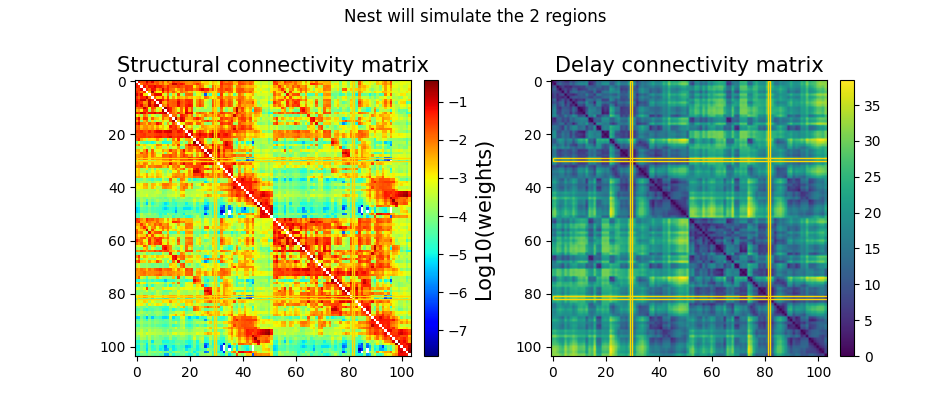

 Nest simulate the following regions :   Right_Entorhinal_area,_lateral_part, Left_Entorhinal_area,_lateral_part


<IPython.core.display.Javascript object>


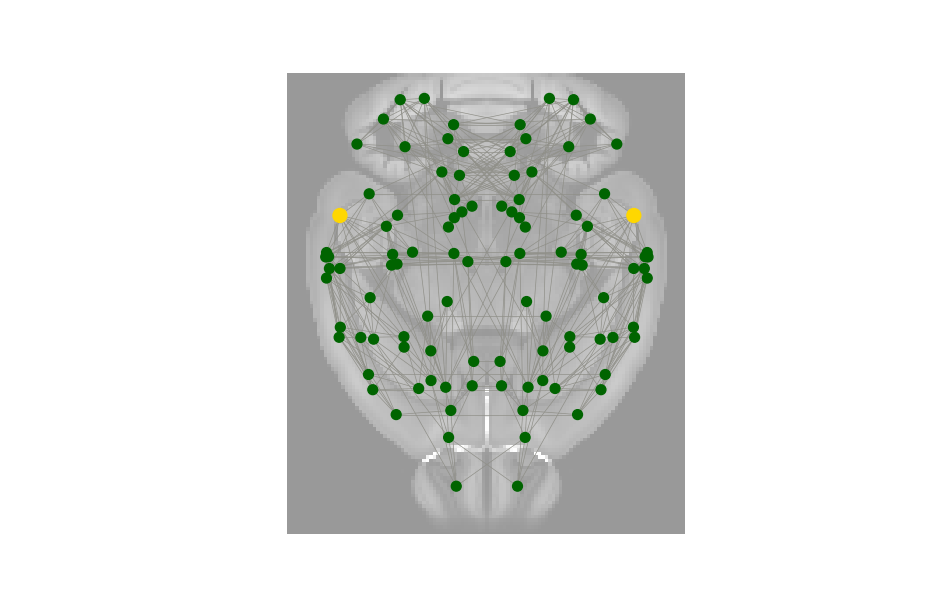

In [22]:
display_connectome(param,image='/home/nest_elephant_tvb/parameter/data_mouse//StruturalMRI_allen_40.npy',
                   color_Nest=color_Nest, color_TVB=color_TVB,
                   size_edges=0.5,
                   threshold=0.05)

# 2 Run the simulation

Run a short simulation of 100.0 ms 

### parameter for the run

In [23]:
begin=0.0                                                 # start recording spikes and nest recording
end=100.0                                                 # end of the simulation
folder_simulation = './short_simulation/'                         # folder use for the simulation

### save parameters <a id="create_link"></a>

Check if the folder for the simulation exists already.

In [24]:
remove_dir = 0
if not os.path.exists(folder_simulation):
    os.mkdir(folder_simulation)
else:
    display(Javascript('var g = confirm("Want you to delete the folder?");if (g){var sentence = "remove_dir=1"}else{var sentence = "remove_dir=2"};IPython.notebook.kernel.execute(sentence);'))

Create the folder and the link between parameter and save the parameters in a file.

In [25]:
if remove_dir == 1:
    for root, dirs, files in os.walk(folder_simulation, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))
    os.rmdir(folder_simulation)
    os.mkdir(folder_simulation)
elif remove_dir == 2:
    remove_dir=0
    raise Exception("You need to remove the folder.")
parameters = create_linked_parameters(folder_simulation,param)
save_parameter(parameters,folder_simulation,begin,end)

In [26]:
size_auto_scroll(10)

<IPython.core.display.Javascript object>

The simulation takes some minutes. You can see the log in the jupyter-server.

In [27]:
orchestrator.run(folder_simulation+'/parameter.json')

Ids of different populations of Nest :

0  800 excitatory
1000  1800 excitatory
800  1000 inhibitory
1800  2000 inhibitory



In [28]:
size_auto_scroll()

<IPython.core.display.Javascript object>

# 3 Show the result

Take data from a long simulation (2s ~ 4h of simulation)

In [29]:
folder_simulation = './short_simulation/'
begin =0.0
end =100.0

## 3.1 Plot data from TVB

Get the state variable of all nodes and initialise.

In [30]:
# get result 
nb_regions = param['param_nest_topology']["nb_region"]
result_raw = get_rate(folder_simulation+'/tvb/')[0] # result of the Raw monitor

# separate the different variable
times =  result_raw[0]
state_variable = np.concatenate(result_raw[1]).reshape(result_raw[1].shape[0],7,nb_regions) # shape : time, state variable, region

TVB record only the excitatory firing rate of excitatory neurons

In [31]:
size_auto_scroll(1000)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


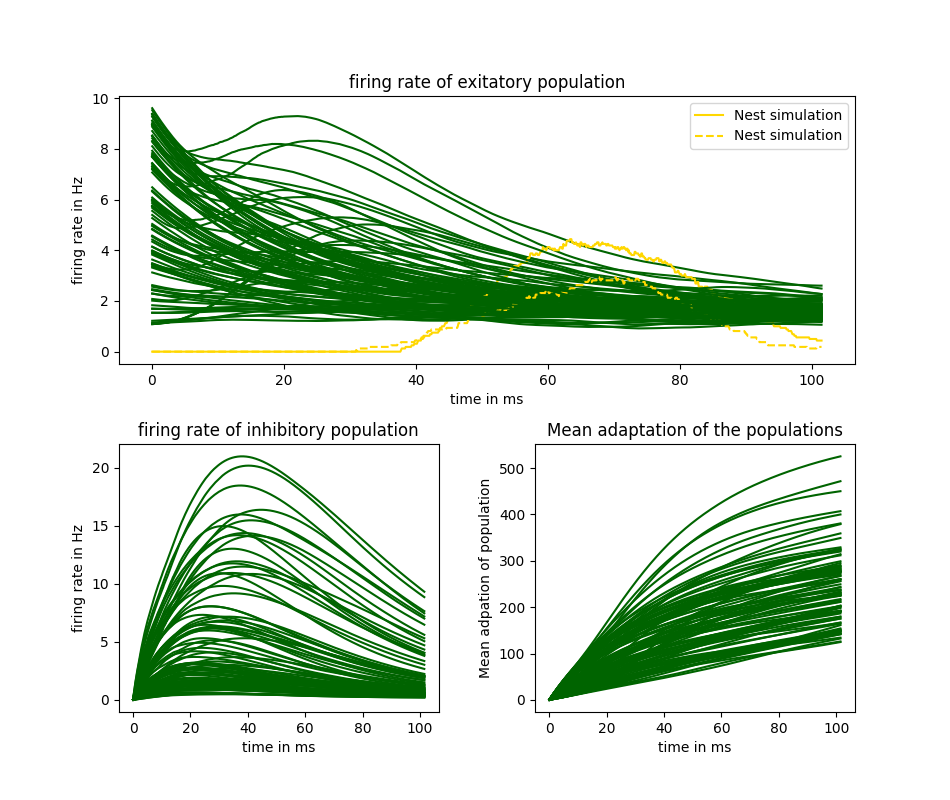

In [32]:
hide_from('time series code')

# customize of the colour of lines
ids =  param['param_co_simulation']["id_region_nest"]
color_lines = [color_TVB for i in range(nb_regions)]
for id in ids:
    color_lines[id] = color_Nest
linestyles = ['-', '--', '-.', ':']
style_lines = ['-' for i in range(nb_regions)]
for index,id in enumerate(ids):
    style_lines[id]=linestyles[index%len(linestyles)]

plt.figure(figsize=(9.5,8))
# plot excitatory firing rate
plt.subplot(211)
plt.plot(times,state_variable[:,0,:]*1e3)
for i,j in enumerate(plt.gca().lines):
    j.set_color(color_lines[i])
    j.set_linestyle(style_lines[i])
for id in ids:
    plt.gca().lines[id].set_label('Nest simulation')
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.legend()
plt.title('firing rate of exitatory population')

# plot inihibitory firing rate
plt.subplot(223)
plt.plot(times,state_variable[:,1,:]*1e3)
for i,j in enumerate(plt.gca().lines):
    j.set_color(color_lines[i])
    j.set_linestyle(style_lines[i])
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.title('firing rate of inhibitory population')

# Print Mean adaptation
plt.subplot(224)
plt.plot(times,state_variable[:,5,:]*1e3)
for i,j in enumerate(plt.gca().lines):
    j.set_color(color_lines[i])
    j.set_linestyle(style_lines[i])
plt.ylabel('Mean adpation of population')
plt.xlabel('time in ms')
plt.title('Mean adaptation of the populations')


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


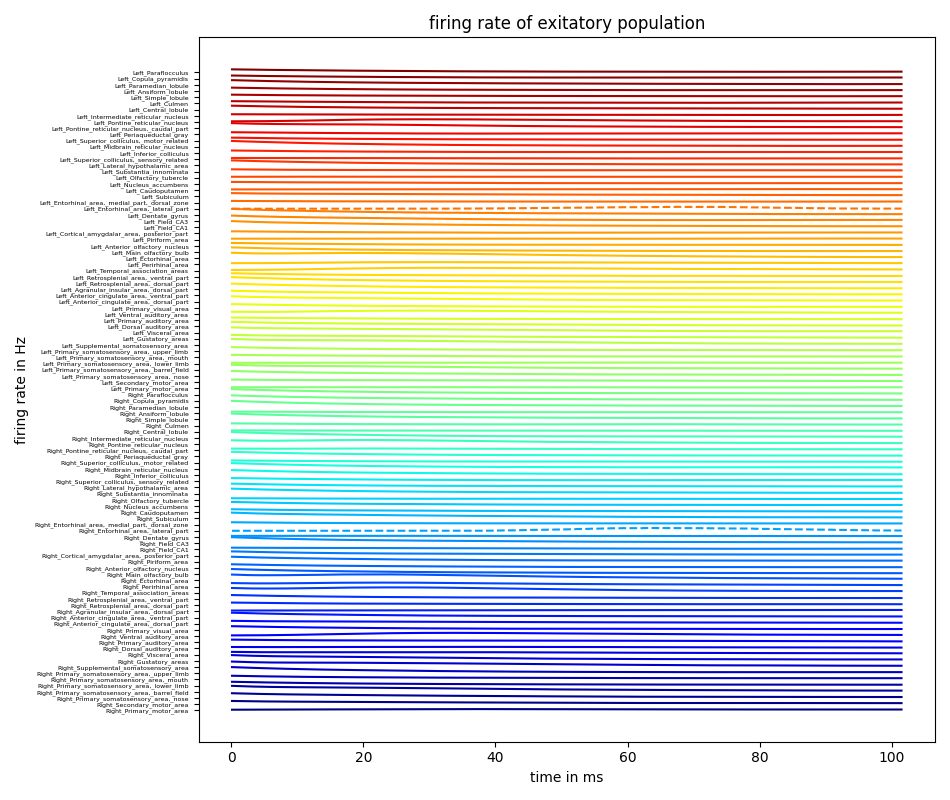

<IPython.core.display.Javascript object>


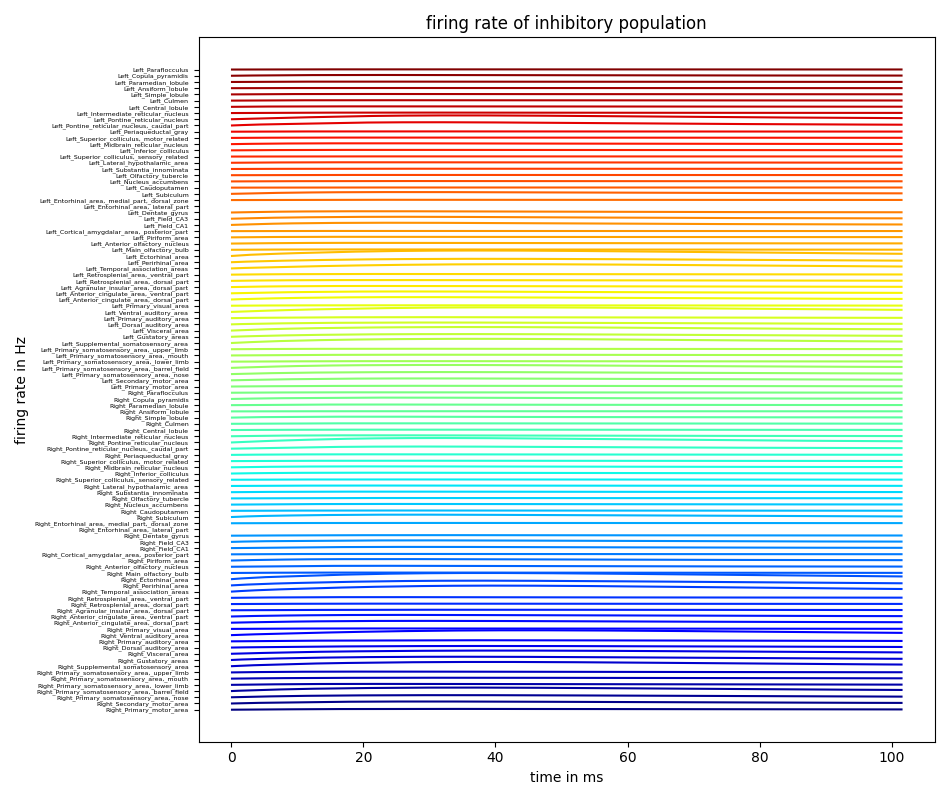

<IPython.core.display.Javascript object>


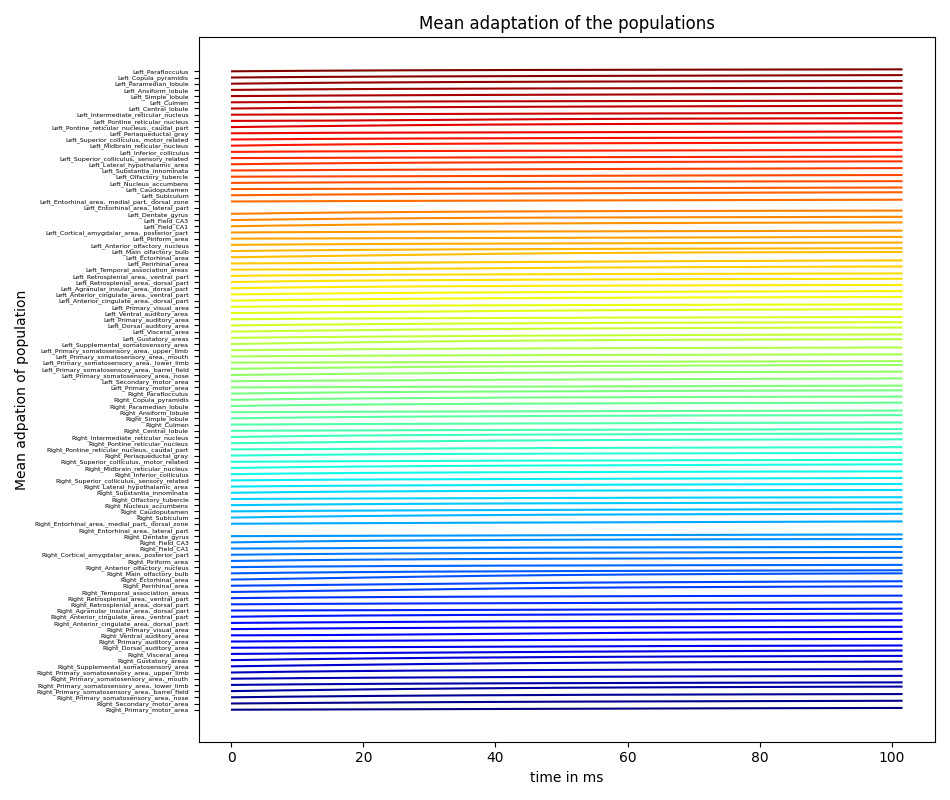

In [33]:
hide_from('raster plot code')

# customize of the colour of lines
custom_cycler = (cycler(color=plt.cm.jet(np.linspace(0, 1,nb_regions))))

# Plot excitatory firing rate
fig=plt.figure(figsize=(9.5,8))
plt.gca().set_prop_cycle(custom_cycler)
max_rate_E = np.nanmax(state_variable[:,0,:])*1e3
for i in range(int(nb_regions)):
    plt.plot(times,state_variable[:,0,i]*1e3+i*max_rate_E)
if 'path_region_labels' in param['param_tvb_connection'].keys():
    labels = np.genfromtxt(param['param_tvb_connection']['path_region_labels'], dtype=str)
    plt.yticks(range(len(labels))*max_rate_E,labels,size=4.5)
for i in ids:
    plt.gca().lines[i].set_linestyle('--')
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.title('firing rate of exitatory population')
fig.tight_layout()

# Plot inhibitory firing rate
fig=plt.figure(figsize=(9.5,8))
plt.gca().set_prop_cycle(custom_cycler)
max_rate_I = np.nanmax(state_variable[:,1,:])*1e3
for i in range(int(nb_regions)):
    plt.plot(times,state_variable[:,1,i]*1e3+i*max_rate_I)
if 'path_region_labels' in param['param_tvb_connection'].keys():
    labels = np.genfromtxt(param['param_tvb_connection']['path_region_labels'], dtype=str)
    plt.yticks(range(len(labels))*max_rate_I,labels,size=4.5)
for i in ids:
    plt.gca().lines[i].set_linestyle('--')
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.title('firing rate of inhibitory population')
fig.tight_layout()

# Plot mean adaptation
fig=plt.figure(figsize=(9.5,8))
max_rate_adp = np.nanmax(state_variable[:,5,:])*1e3
plt.gca().set_prop_cycle(custom_cycler)
for i in range(int(nb_regions)):
    plt.plot(times,state_variable[:,5,i]*1e3+i*max_rate_adp)
if 'path_region_labels' in param['param_tvb_connection'].keys():
    labels = np.genfromtxt(param['param_tvb_connection']['path_region_labels'], dtype=str)
    plt.yticks(range(len(labels))*max_rate_adp,labels,size=4.5)
for i in ids:
    plt.gca().lines[i].set_linestyle('--')
plt.ylabel('Mean adpation of population')
plt.xlabel('time in ms')
plt.title('Mean adaptation of the populations')
fig.tight_layout()

plt.show()

In [34]:
size_auto_scroll()

<IPython.core.display.Javascript object>

## 3.2 Plot simulated data from Nest

Get the result of all the different recorders of Nest. 

In [35]:
data_nest = get_data_all(folder_simulation+'/nest/')
print( "name of the recording data from Nest record:",list(data_nest.keys()))

name of the recording data from Nest record: ['pop_1_ex_VM', 'pop_1_ex_W', 'pop_1_in_VM', 'pop_1_in_W', 'pop_1_ex', 'pop_2_ex', 'pop_1_in', 'pop_2_in']


### 3.2.a Plot data from the Right Entorhinal area lateral part

<IPython.core.display.Javascript object>


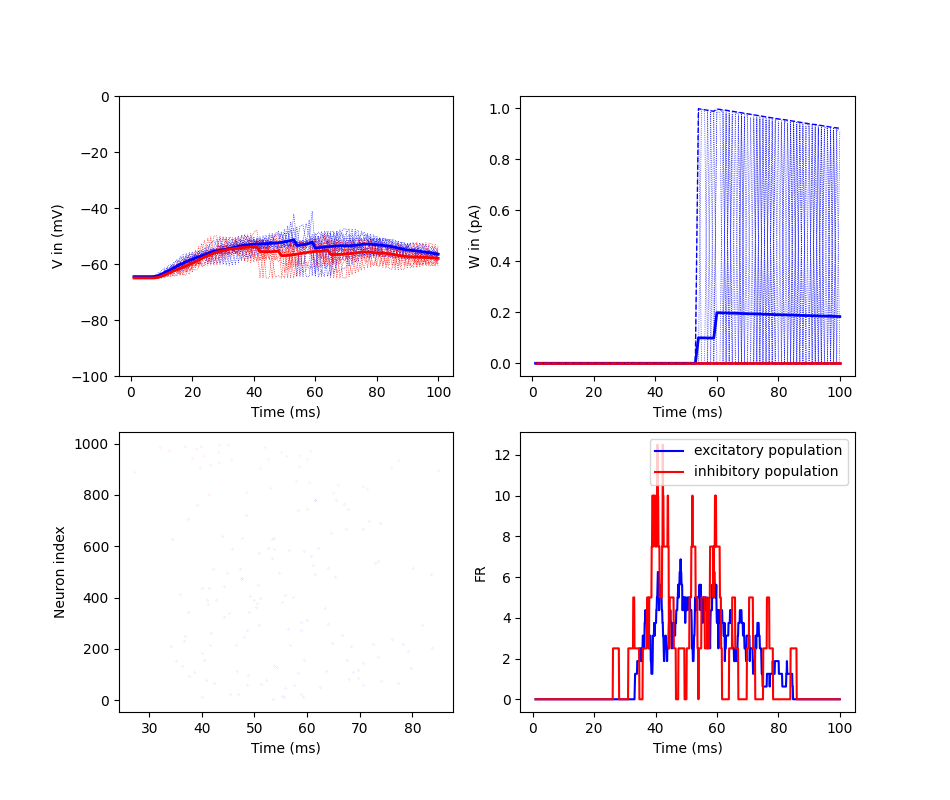

<IPython.core.display.Javascript object>


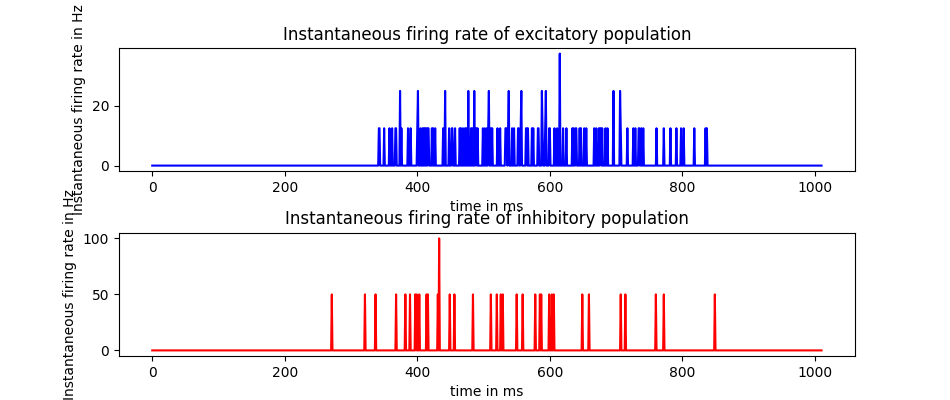

In [36]:
print_nest_pop(param,begin,end,data_nest['pop_1_ex'],data_nest['pop_1_in'],
               V_ex=data_nest['pop_1_ex_VM'],V_in=data_nest['pop_1_in_VM'],
               W_ex=data_nest['pop_1_ex_W'],W_in=data_nest['pop_1_in_W'],
                histogram=True)

### 3.2.a Plot data from the Left Entorhinal area lateral part

<IPython.core.display.Javascript object>


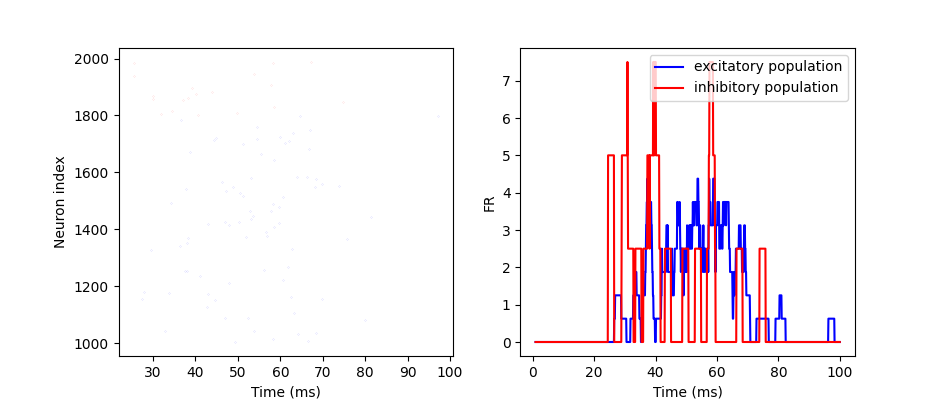

<IPython.core.display.Javascript object>


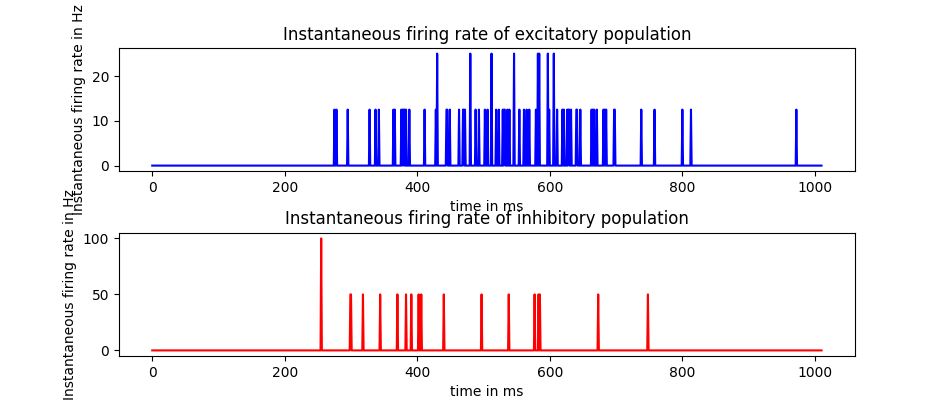

In [37]:
print_nest_pop(param,begin,end,data_nest['pop_2_ex'],data_nest['pop_2_in'],
                histogram=True)

## References

<a id='brette_2005'> [Brette and Gerstner 2005]</a>  Romain Brette and Wulfram Gerstner. “Adaptive Exponential Integrate-and-Fire Model as an Effective Description of Neuronal Activity.” Journal of Neurophysiology 94, no. 5 (November 1, 2005): 3637–42. https://doi.org/10.1152/jn.00686.2005.


<a id='di_volo2019'> [ Di Volo 2019 ]</a>  Matteo Di Volo, Alberto Romagnoni, Cristiano Capone, and Alain Destexhe. “Biologically Realistic Mean-Field Models of Conductance-Based Networks of Spiking Neurons with Adaptation.” Neural Computation 31, no. 4 (February 14, 2019): 653–80. https://doi.org/10.1162/neco_a_01173.
